### Authors

* **Deepak Hazarika** 
* **Parinita Bora**
* **Gurudatta**

# Import Libraries

In [ ]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import logging
import sys
from datetime import datetime

now = datetime.now()

#sys.stdout = open('logfile' + str(now) + '.log','a')

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    filename='logfile.log',
                    filemode='a')

logging.info("Start " + str(now))
print("Start of logging V2 " + str(now))

Start of logging V2 2020-08-21 15:14:45.942217


## Params

* Batch_size
* learning rate

In [ ]:
BATCH_SIZE = 128
LR = 0.028
MODEL_VERSION = 2
modelinfo =  "Model version- " + str( MODEL_VERSION) + ", Bacth size- " + str(BATCH_SIZE) + ", Learning rate- " + str(LR) 

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9, 1.1)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
modelinfo = modelinfo + " Random affine 10 and Random color jitter 0.1 + relu in conv6 + gap at end" 
print(modelinfo)

Model version- 2, Bacth size- 128, Learning rate- 0.028 Random affine 10 and Random color jitter 0.1 + relu in conv6 + gap at end


In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=BATCH_SIZE)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        c_in = 1
        c_out = 9
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        c_in = 9
        c_out = 9
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU()
        ) # output_size = 24
        
        c_in = 9
        c_out = 9
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        
        c_in = 9
        c_out = 16
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU()
        ) # output_size = 9

        # CONVOLUTION BLOCK 2
        c_in = 16
        c_out = 16
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU()
        ) # output_size = 7
        c_in = 16
        c_out = 16
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU()
        ) # output_size = 5

        c_in = 16
        c_out = 10
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 5

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 26, 26]              81
       BatchNorm2d-2            [-1, 9, 26, 26]              18
              ReLU-3            [-1, 9, 26, 26]               0
            Conv2d-4            [-1, 9, 24, 24]             729
       BatchNorm2d-5            [-1, 9, 24, 24]              18
              ReLU-6            [-1, 9, 24, 24]               0
            Conv2d-7            [-1, 9, 22, 22]             729
       BatchNorm2d-8            [-1, 9, 22, 22]              18
              ReLU-9            [-1, 9, 22, 22]               0
        MaxPool2d-10            [-1, 9, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           1,296
      BatchNorm2d-12             [-1, 16, 9, 9]              32
             ReLU-13             [-1, 16, 9, 9]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.item(), correct, processed ,
        100. * correct / processed))
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.12271014600992203 Batch_id=468 Accuracy=88.67: 100%|██████████| 469/469 [00:31<00:00, 15.08it/s]


Train set: Average loss: 0.1227, Accuracy: 53200/60000 (88.67%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0526, Accuracy: 9834/10000 (98.34%)

EPOCH: 1


Loss=0.12151794880628586 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:31<00:00, 14.82it/s]


Train set: Average loss: 0.1215, Accuracy: 58343/60000 (97.24%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9883/10000 (98.83%)

EPOCH: 2


Loss=0.1321476250886917 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:31<00:00, 14.79it/s]


Train set: Average loss: 0.1321, Accuracy: 58561/60000 (97.60%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9876/10000 (98.76%)

EPOCH: 3


Loss=0.020135564729571342 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:31<00:00, 15.01it/s]


Train set: Average loss: 0.0201, Accuracy: 58729/60000 (97.88%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9904/10000 (99.04%)

EPOCH: 4


Loss=0.03704048693180084 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:31<00:00, 15.05it/s]


Train set: Average loss: 0.0370, Accuracy: 58903/60000 (98.17%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.023531779646873474 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:31<00:00, 14.87it/s]


Train set: Average loss: 0.0235, Accuracy: 58901/60000 (98.17%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9915/10000 (99.15%)

EPOCH: 6


Loss=0.12067568302154541 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:32<00:00, 14.32it/s]


Train set: Average loss: 0.1207, Accuracy: 58974/60000 (98.29%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.11337915807962418 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:31<00:00, 14.69it/s]



Train set: Average loss: 0.1134, Accuracy: 59075/60000 (98.46%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.03403449431061745 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:31<00:00, 14.89it/s]


Train set: Average loss: 0.0340, Accuracy: 59150/60000 (98.58%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9924/10000 (99.24%)

EPOCH: 9


Loss=0.005242590326815844 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:31<00:00, 15.01it/s]



Train set: Average loss: 0.0052, Accuracy: 59117/60000 (98.53%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9938/10000 (99.38%)

EPOCH: 10


Loss=0.07906689494848251 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:31<00:00, 14.70it/s]


Train set: Average loss: 0.0791, Accuracy: 59124/60000 (98.54%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.06568527966737747 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:31<00:00, 14.76it/s]


Train set: Average loss: 0.0657, Accuracy: 59163/60000 (98.61%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9920/10000 (99.20%)

EPOCH: 12


Loss=0.03795526549220085 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:32<00:00, 14.41it/s]


Train set: Average loss: 0.0380, Accuracy: 59172/60000 (98.62%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9940/10000 (99.40%)

EPOCH: 13


Loss=0.1338934451341629 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:32<00:00, 14.37it/s]


Train set: Average loss: 0.1339, Accuracy: 59174/60000 (98.62%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9946/10000 (99.46%)

EPOCH: 14


Loss=0.030126243829727173 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:32<00:00, 14.28it/s]


Train set: Average loss: 0.0301, Accuracy: 59229/60000 (98.72%)




Test set: Average loss: 0.0198, Accuracy: 9930/10000 (99.30%)



Text(0.5, 1.0, 'Test Accuracy')

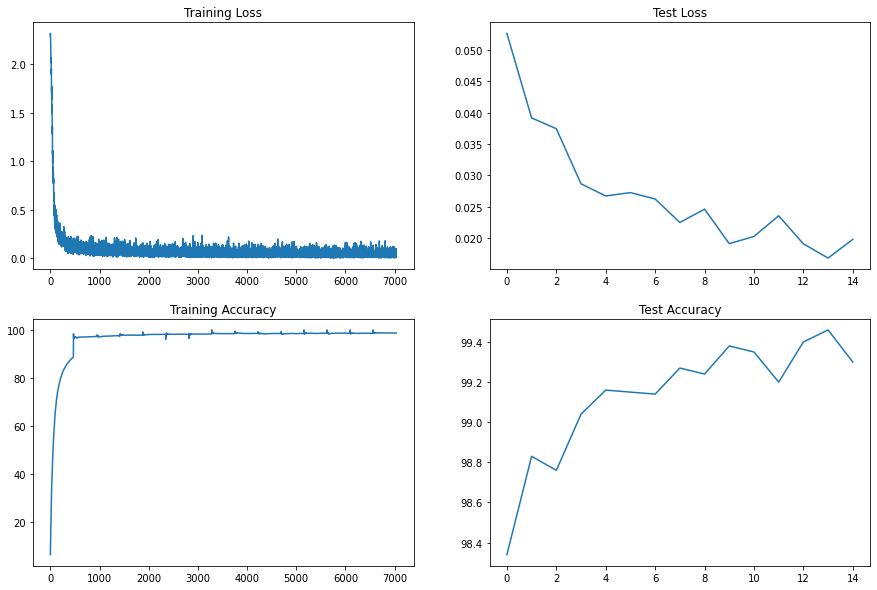

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
now = datetime.now()

print("End of logging V2" + str(now))

End of logging V22020-08-21 15:23:23.112237
